In [1]:
import sys
sys.path.append("../") # adding the path to read the utils file
from sklearnex import patch_sklearn
patch_sklearn(global_patch=True)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics, tree
from shap import TreeExplainer, KernelExplainer
from imblearn.under_sampling import RandomUnderSampler
import fasttreeshap
from shap import plots, Explanation
import graphviz 
from yellowbrick.model_selection import LearningCurve
import time
import pickle
from utils import *
from yellowbrick.classifier import ROCAUC
from yellowbrick.contrib.wrapper import wrap

pd.set_option('display.max_columns', None)

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# you should run making_hikari2022_csv.ipynb before running this cell, since the two csv given with the paper have two differences
# to see what are the data types and the features of the dataset, you can take a look on the utils file
ds = pd.concat([
    pd.read_csv('../datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2021.csv', dtype=dtype_hikari, usecols=selected_features_hikari),
    pd.read_csv('../datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2022.csv', dtype=dtype_hikari, usecols=selected_features_hikari)], 
    ignore_index=True)
ds.head()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,2.207588,15,14,6,6,6.794746,6.341763,13.136509,0.933333,464,20,40,492,32,44,2,2,2,6,5,26,0,0,0,0,0,742,1826.0,121.733333,220.736581,0,1448,5025.0,358.928571,552.239840,0,1448,6851.0,236.241379,424.859275,18.119812,1.963762e+06,2.207603e+06,1.576859e+05,5.205052e+05,7.867813,2.032929e+06,2.177950e+06,1.675346e+05,5.606267e+05,7.867813,1.963762e+06,2.207603e+06,78842.963491,3.696378e+05,3103.387105,7.5,7.0,913.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.207603e+06,2.207603e+06,2.207603e+06,2.207603e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,True
1,15.624266,15,14,6,6,0.960045,0.896042,1.856087,0.933333,488,20,44,468,32,44,2,2,2,6,5,26,0,0,0,0,0,745,1829.0,121.933333,221.339257,0,1448,5025.0,358.928571,552.239840,0,1448,6854.0,236.344828,424.987166,20.980835,1.534300e+07,1.562428e+07,1.116020e+06,4.094889e+06,20.980835,1.541144e+07,1.559517e+07,1.199628e+06,4.270148e+06,10.013580,1.534300e+07,1.562428e+07,558009.896960,2.897622e+06,438.676603,7.5,7.0,914.5,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.883792e+04,2.524381e+05,2.812760e+05,1.406380e+05,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,True
2,12.203357,14,13,6,5,1.147225,1.065281,2.212506,0.928571,432,20,40,448,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,36.001205,1.196814e+07,1.220338e+07,9.387216e+05,3.314032e+06,15.020370,1.203674e+07,1.217482e+07,1.014569e+06,3.471107e+06,15.020370,1.196814e+07,1.220338e+07,469360.810060,2.345336e+06,561.566789,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.891302e+04,2.063251e+05,2.352381e+05,1.176190e+05,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,True
3,9.992448,14,13,6,5,1.401058,1.300983,2.702041,0.928571,432,20,40,436,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,50.067902,9.759205e+06,9.992470e+06,7.686515e+05,2.701448e+06,20.980835,9.828447e+06,9.963348e+06,8.302790e+05,2.833716e+06,20.980835,9.759205e+06,9.992470e+06,384325.770231,1.912152e+06,685.817940,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.952909e+04,2.037361e+05,2.332652e+05,1.166326e+05,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,True
4,7.780611,14,14,6,5,1.799345,1.799345,3.598689,1.000000,432,20,40,480,32,44,2,2,2,6,5,25,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,358.928571,792.173394,0,2896,6853.0,244.750000,583.468215,16.927719,7.545305e+06,7.780620e+06,5.985092e+

In [3]:
compute_ratio(ds,'traffic_category')

                     Ratio
traffic_category          
Benign               71.77
Background           21.72
Probing               2.98
XMRIGCC CryptoMiner   1.39
Bruteforce-XML        1.12
Bruteforce            1.02


In [4]:
# "class_weight": {0: 1, 1: 0.8} the model tends to predict more 1 than 0, so if you want to balance the prediction, you can use this parameter

params = {
    "random_state": 0,
    "max_depth": 14
}

dt = DecisionTreeClassifier(**params)

rus = RandomUnderSampler(random_state=42, sampling_strategy='all')
X_res, y_res = rus.fit_resample(ds[x_features], ds['traffic_category'])

In [5]:
y_res.value_counts()

traffic_category
Background             7988
Benign                 7988
Bruteforce             7988
Bruteforce-XML         7988
Probing                7988
XMRIGCC CryptoMiner    7988
Name: count, dtype: int64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state=12, shuffle=True, stratify=y_res)

In [7]:
pd.unique(y_train)

array(['Bruteforce', 'Background', 'Benign', 'Probing', 'Bruteforce-XML',
       'XMRIGCC CryptoMiner'], dtype=object)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel

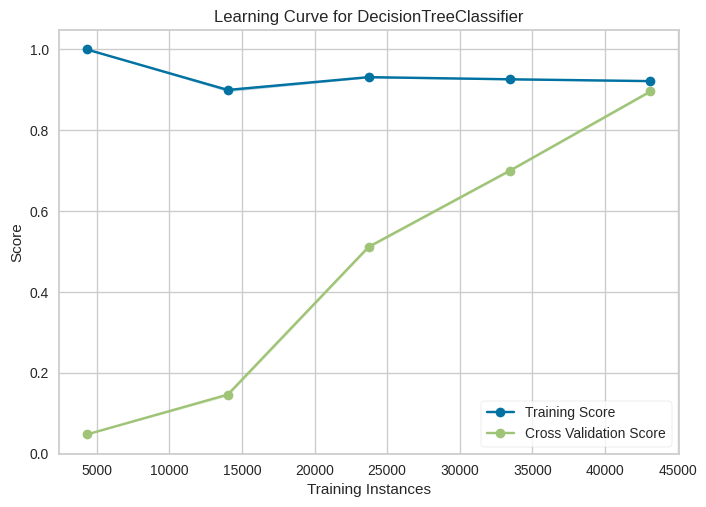

In [8]:
if True:
    cv = 10
    visualizer = LearningCurve(estimator=dt, cv=cv, scoring='f1_weighted', n_jobs=-1, random_state=123)
    visualizer.fit(X_res, y_res)
    visualizer.show(outpath="dt_data/learning_curve.png")


In [9]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X_res, y_res)

5

In [10]:
avg_train_f1 = []
avg_test_f1 = []

for i, (train_index, test_index) in enumerate(skf.split(X_res, y_res)):
    print(f"Fold {i}:")
    dt.fit(X_res.iloc[train_index], y_res.iloc[train_index])
    y_predicted_train = dt.predict(X_res.iloc[train_index])
    y_predicted_test = dt.predict(X_res.iloc[test_index])
    train_f1 = metrics.f1_score(y_res.iloc[train_index], y_predicted_train, average='weighted')
    test_f1 = metrics.f1_score(y_res.iloc[test_index], y_predicted_test, average='weighted')
    print(f"Train F1: {train_f1:.4f}")
    print(f"Test F1: {test_f1:.4f}")
    avg_train_f1.append(train_f1)
    avg_test_f1.append(test_f1)

print(f"Average Train F1: {np.mean(avg_train_f1):.4f}")
print(f"Average Test F1: {np.mean(avg_test_f1):.4f}")

Fold 0:
Train F1: 0.9219
Test F1: 0.8958
Fold 1:
Train F1: 0.9227
Test F1: 0.9002
Fold 2:
Train F1: 0.9235
Test F1: 0.8935
Fold 3:
Train F1: 0.9213
Test F1: 0.8950
Fold 4:
Train F1: 0.9215
Test F1: 0.8979
Average Train F1: 0.9222
Average Test F1: 0.8965


In [11]:
%time dt.fit(X_train, y_train)

CPU times: user 4.13 s, sys: 1.15 ms, total: 4.13 s
Wall time: 4.15 s


DecisionTreeClassifier(max_depth=14, random_state=0)

In [12]:
%time y_predicted_train = dt.predict(X_train)
%time y_predicted_test = dt.predict(X_test)

CPU times: user 60.8 ms, sys: 4.99 ms, total: 65.7 ms
Wall time: 65.5 ms
CPU times: user 20.1 ms, sys: 0 ns, total: 20.1 ms
Wall time: 20.5 ms


In [13]:
pd.unique(y_train)

array(['Bruteforce', 'Background', 'Benign', 'Probing', 'Bruteforce-XML',
       'XMRIGCC CryptoMiner'], dtype=object)

In [14]:
# Function to create dataframe with metrics
def performanceMetricsDF(
    metricsObj, yTrain, yPredTrain, yTest, yPredTest, average="binary"
):
    measures_list = ["ACCURACY", "PRECISION", "RECALL", "F1 SCORE"]
    train_results = [
        metricsObj.accuracy_score(yTrain, yPredTrain),
        metricsObj.precision_score(yTrain, yPredTrain, average=average),
        metricsObj.recall_score(yTrain, yPredTrain, average=average),
        metricsObj.f1_score(yTrain, yPredTrain, average=average),
    ]
    test_results = [
        metricsObj.accuracy_score(yTest, yPredTest),
        metricsObj.precision_score(yTest, yPredTest, average=average),
        metricsObj.recall_score(yTest, yPredTest, average=average),
        metricsObj.f1_score(yTest, yPredTest, average=average),

    ]
    resultsDF = pd.DataFrame(
        {"Measure": measures_list, "Train": train_results, "Test": test_results}
    )
    return resultsDF

In [15]:
performanceMetricsDF(metrics, y_train, y_predicted_train, y_test, y_predicted_test, 'weighted')

,Measure,Train,Test
0,ACCURACY,0.924860,0.902775
1,PRECISION,0.925107,0.899462
2,RECALL,0.924860,0.902775
3,F1 SCORE,0.922171,0.899013


X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


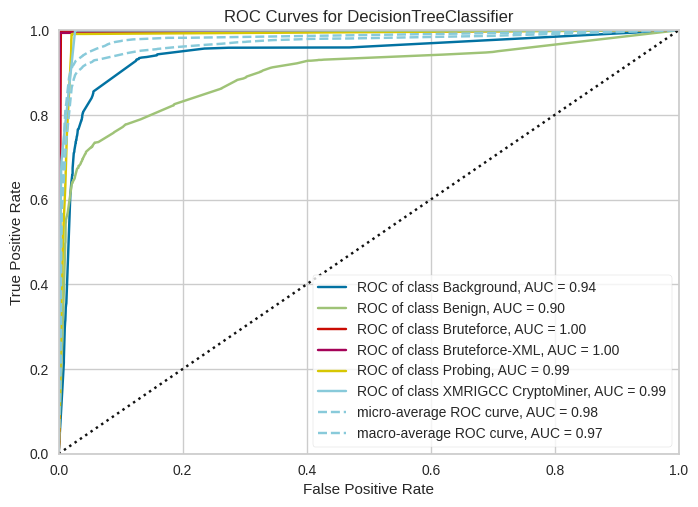

<Axes: title={'center': 'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [16]:
model = wrap(dt)
visualizer = ROCAUC(model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

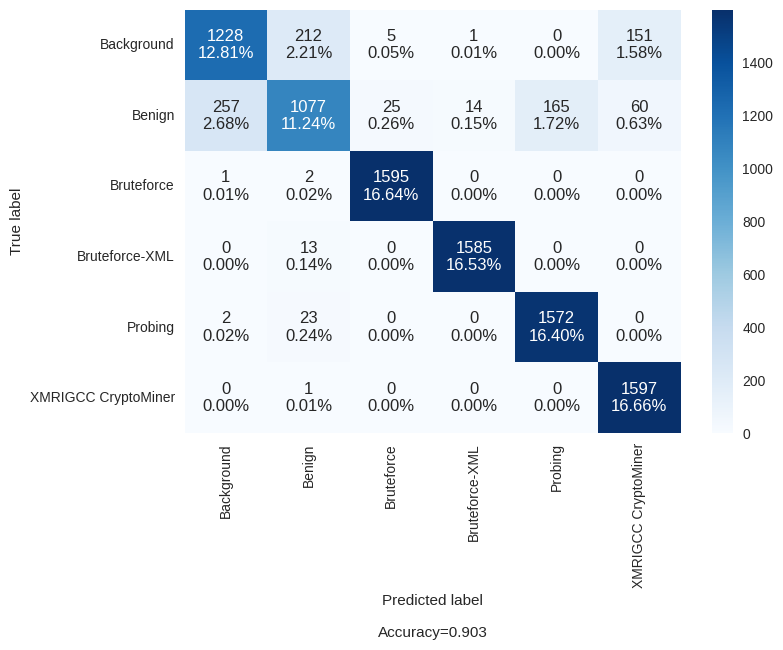

In [17]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(dt.classes_)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [18]:
dot_data = tree.export_graphviz(dt, feature_names=x_features, out_file=None, class_names=dt.classes_) 
graph = graphviz.Source(dot_data)
graph.render('tree/dt')

'tree/dt.pdf'

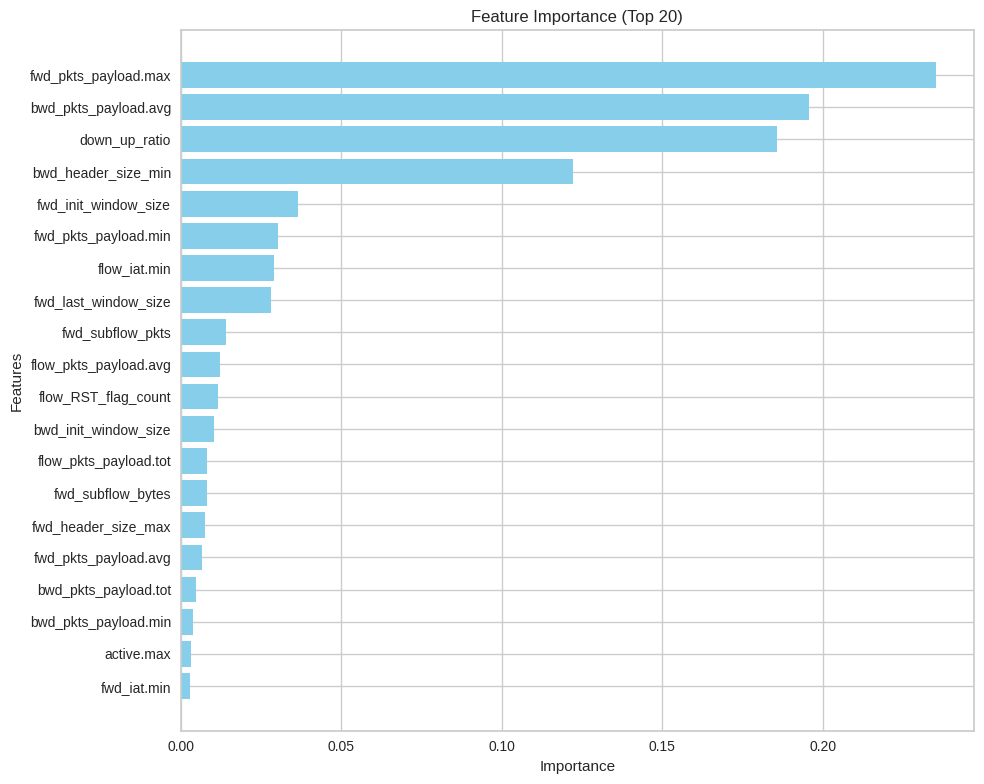

In [19]:
feature_importance = dt.feature_importances_
x_features_np = np.array(x_features)

# Sort indices based on feature importance
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_features = x_features_np[sorted_indices][:20][::-1]  # Select only the first 20 features
sorted_importance = feature_importance[sorted_indices][:20][::-1]  # Select importance values for the first 20 features

# Plotting
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
plt.barh(range(len(sorted_importance)), sorted_importance, color='skyblue')
plt.yticks(range(len(sorted_importance)), sorted_features)  # Use yticks for feature names
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Feature Importance (Top 20)')
plt.tight_layout()

# Show plot
plt.show()

In [20]:
%%time

explainer = fasttreeshap.TreeExplainer(dt, algorithm='auto', n_jobs=-1) 
sv = explainer(X_train)

CPU times: user 4.78 s, sys: 5.45 s, total: 10.2 s
Wall time: 5.13 s


In [21]:
dt.classes_

array(['Background', 'Benign', 'Bruteforce', 'Bruteforce-XML', 'Probing',
       'XMRIGCC CryptoMiner'], dtype=object)

## Background

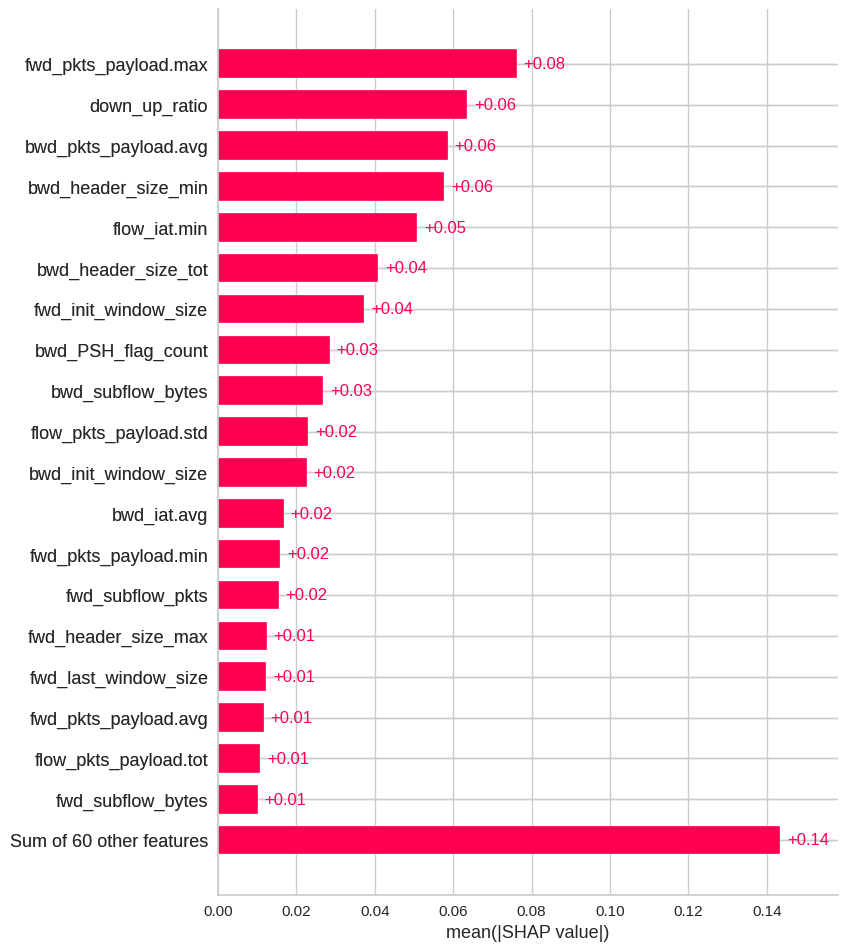

In [22]:
exp = Explanation(sv.values[:,:,0], 
                  sv.base_values[:,0],
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

## Benign

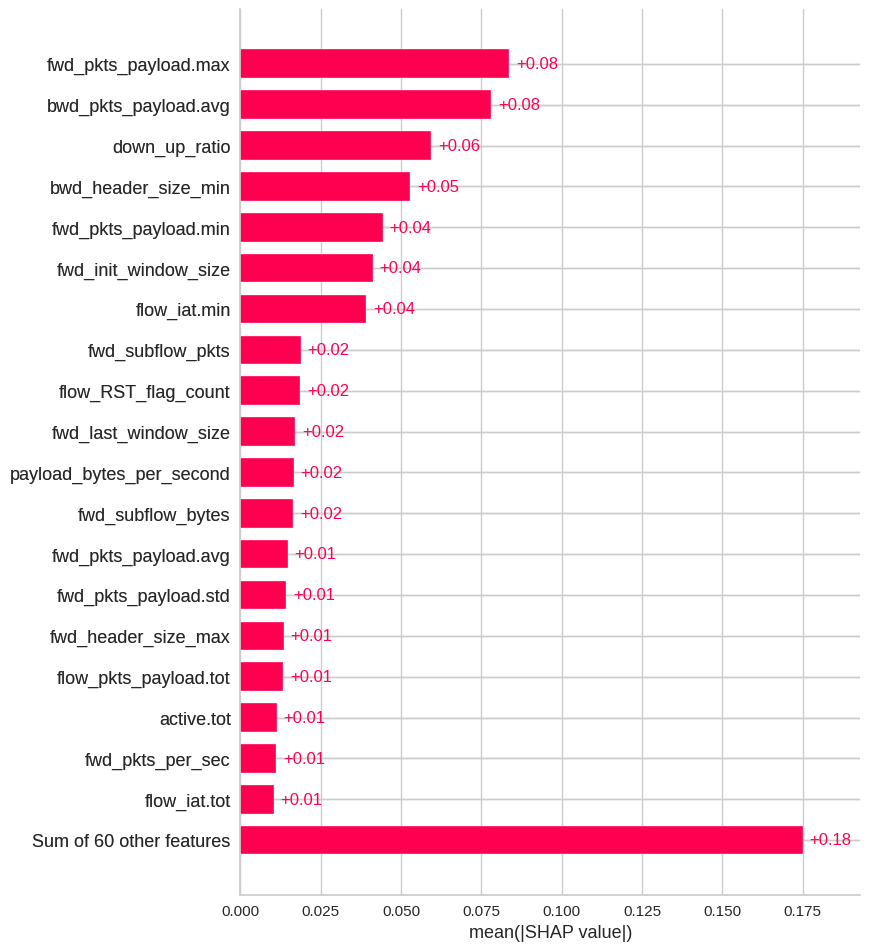

In [23]:
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1],
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

## Bruteforce

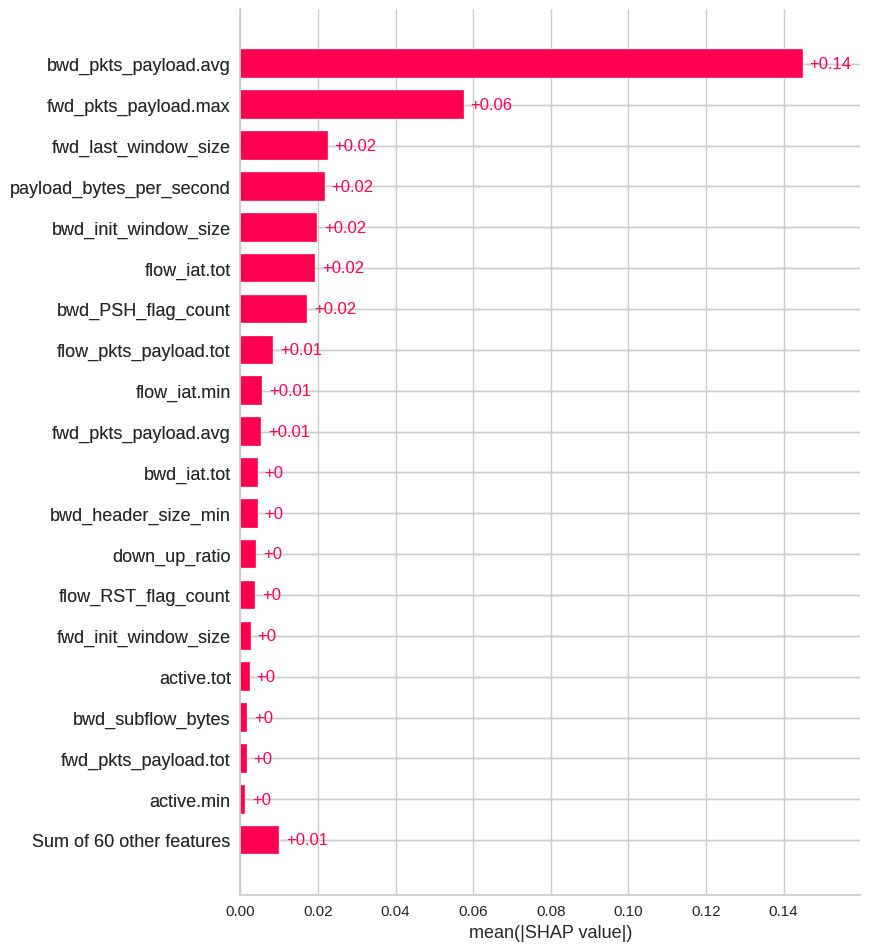

In [24]:
exp = Explanation(sv.values[:,:,2], 
                  sv.base_values[:,2],
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

## Bruteforce XML shap


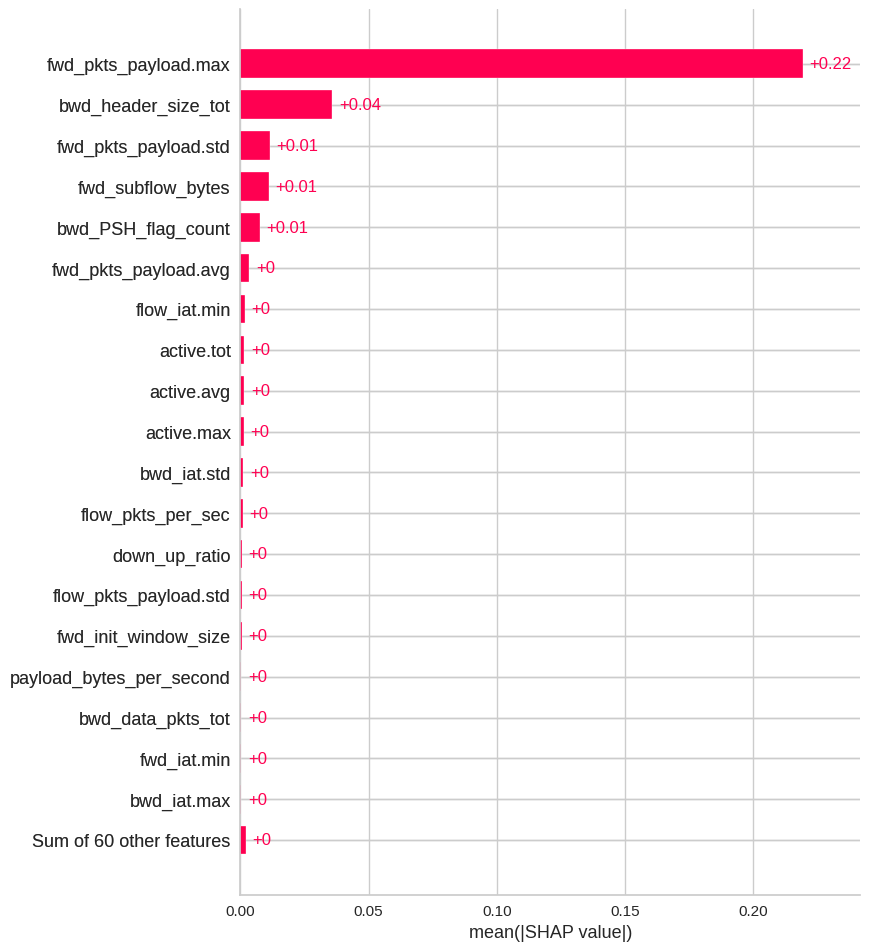

In [25]:
exp = Explanation(sv.values[:,:,3], 
                  sv.base_values[:,3],
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

## Probing shap

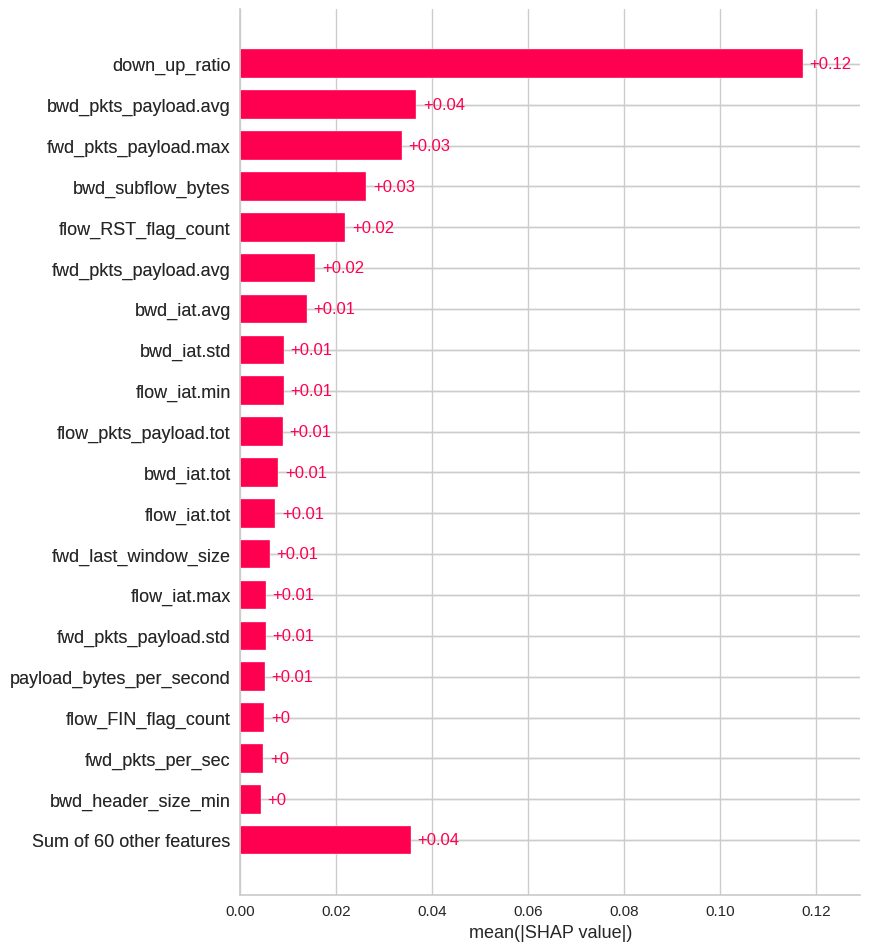

In [26]:
exp = Explanation(sv.values[:,:,4], 
                  sv.base_values[:,4],
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

## Miner shap

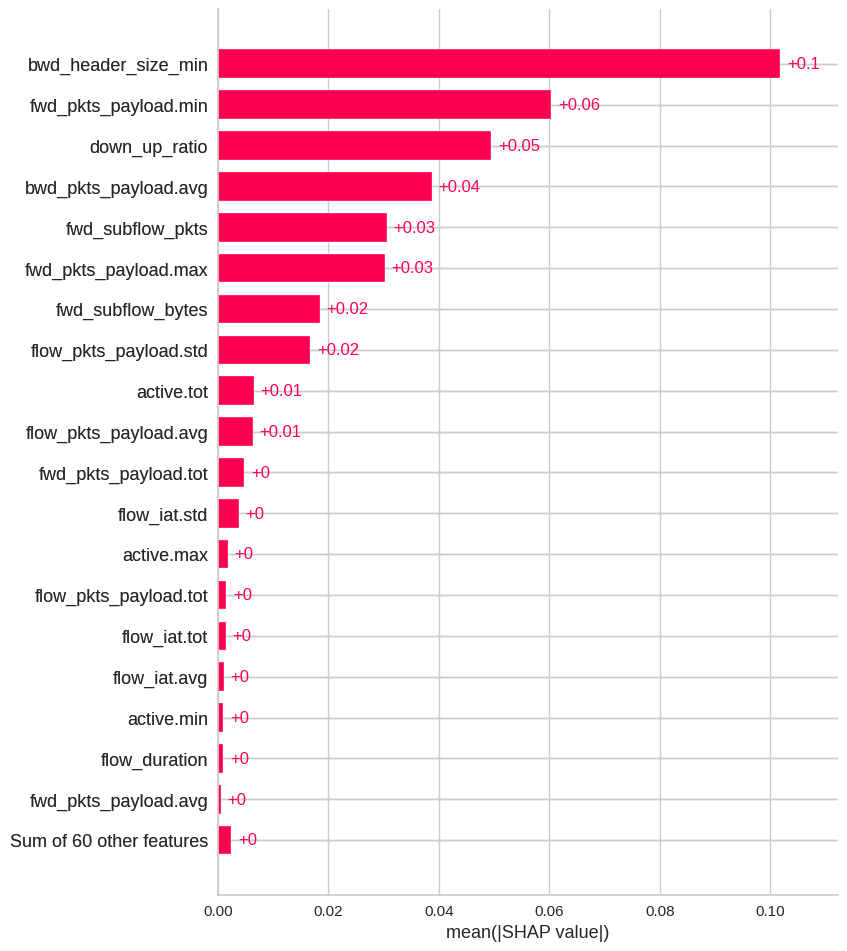

In [27]:
exp = Explanation(sv.values[:,:,5], 
                  sv.base_values[:,5],
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

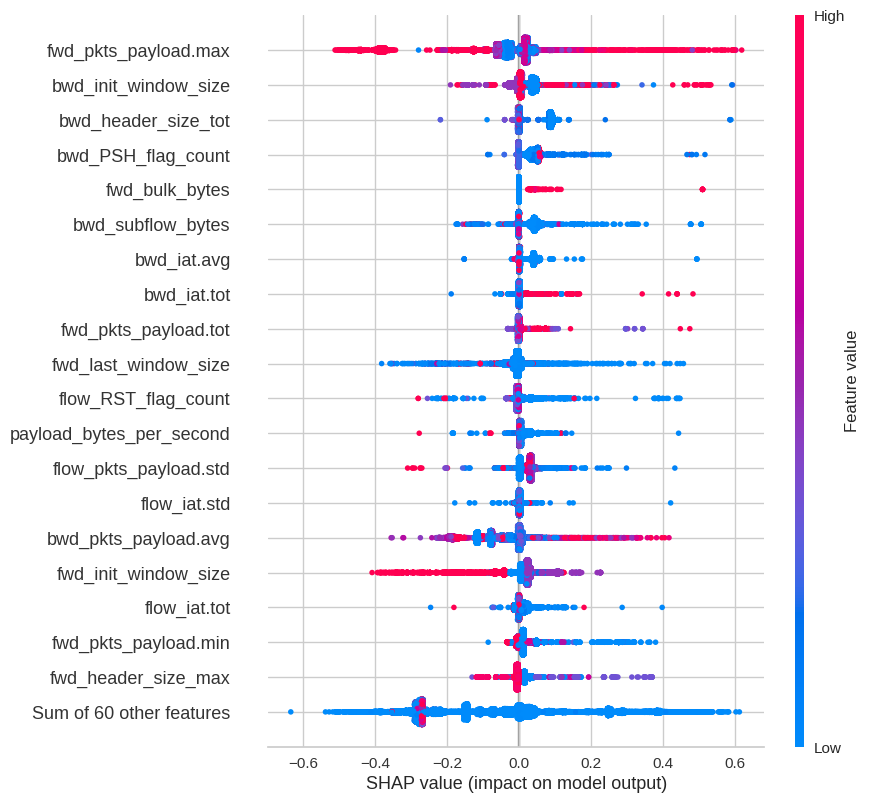

In [28]:
exp = Explanation(sv.values[:,:,0], 
                  sv.base_values[:,0],
                  data=X_train, 
                  feature_names=x_features)

plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

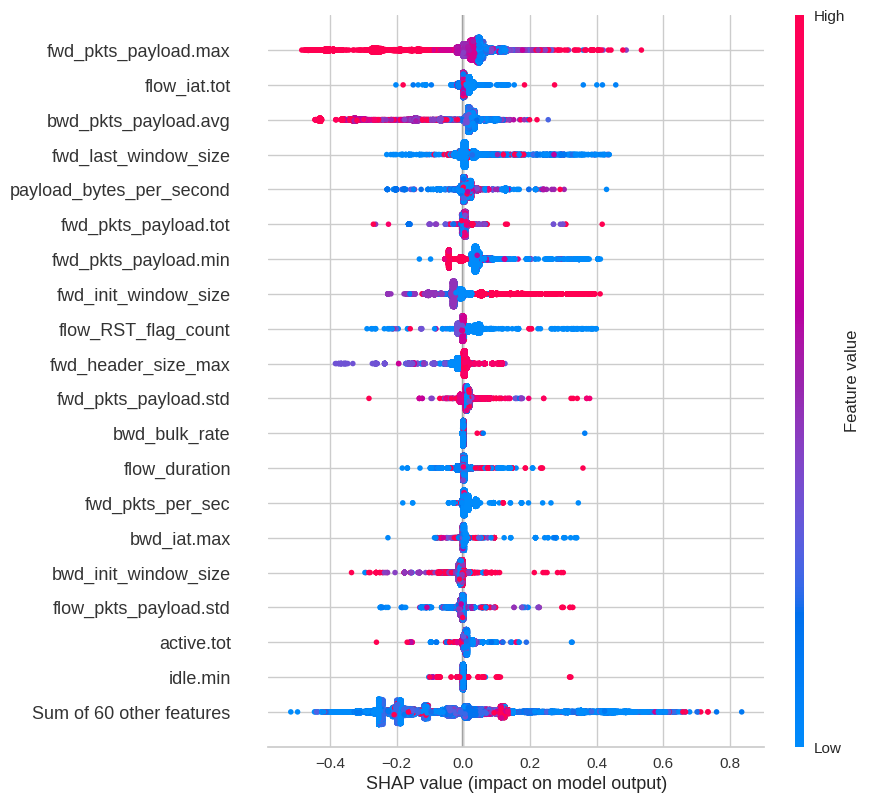

In [29]:
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1],
                  data=X_train, 
                  feature_names=x_features)

plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

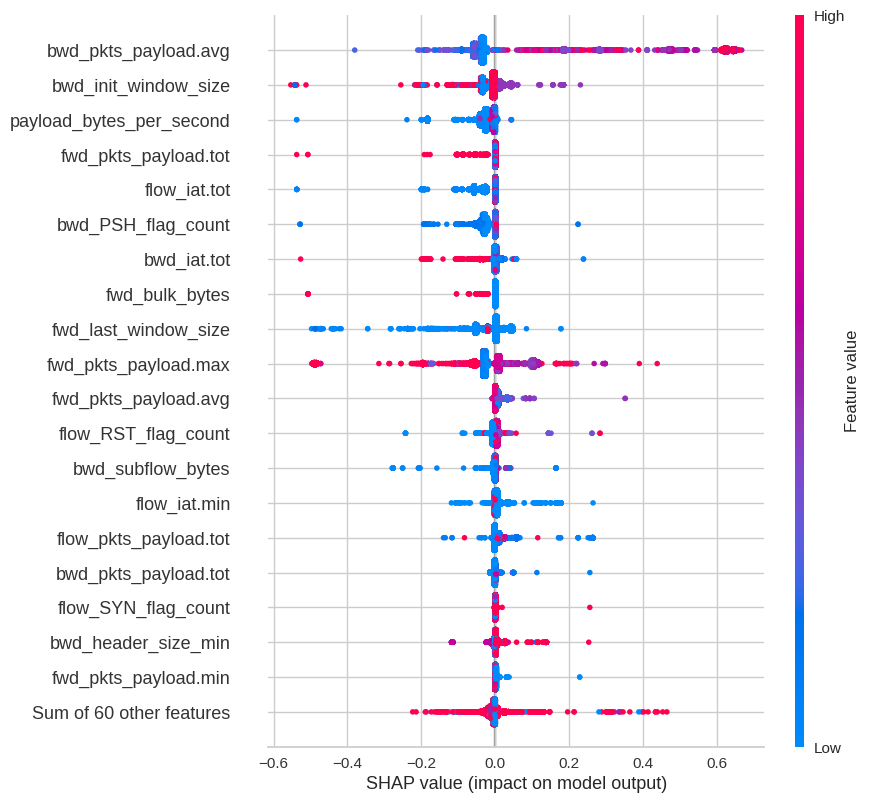

In [30]:
exp = Explanation(sv.values[:,:,2], 
                  sv.base_values[:,2],
                  data=X_train, 
                  feature_names=x_features)

plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

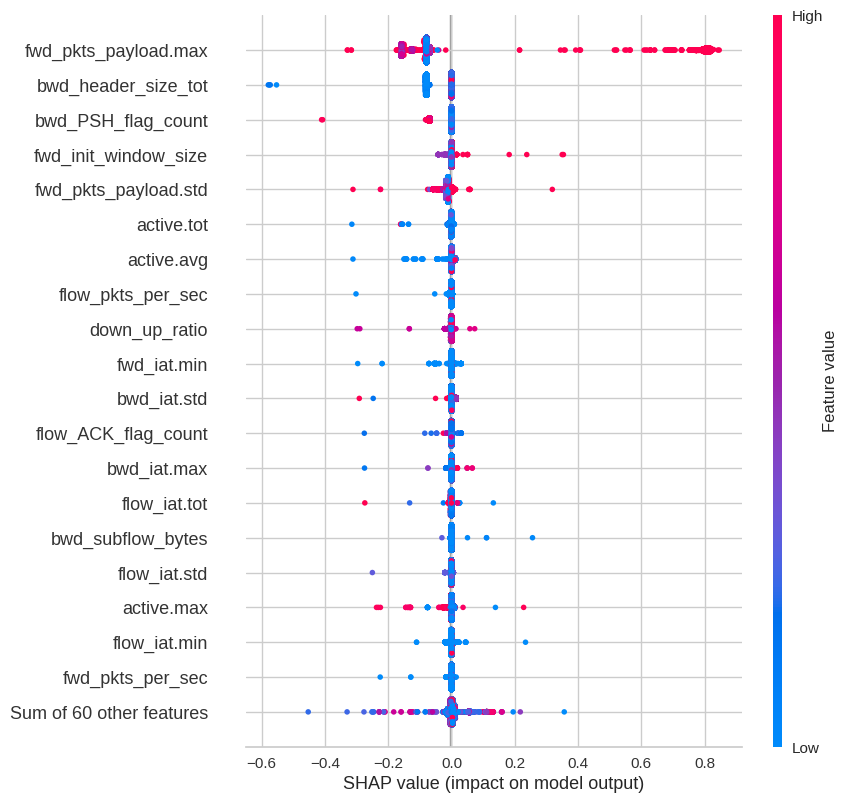

In [31]:
exp = Explanation(sv.values[:,:,3], 
                  sv.base_values[:,3],
                  data=X_train, 
                  feature_names=x_features)

plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

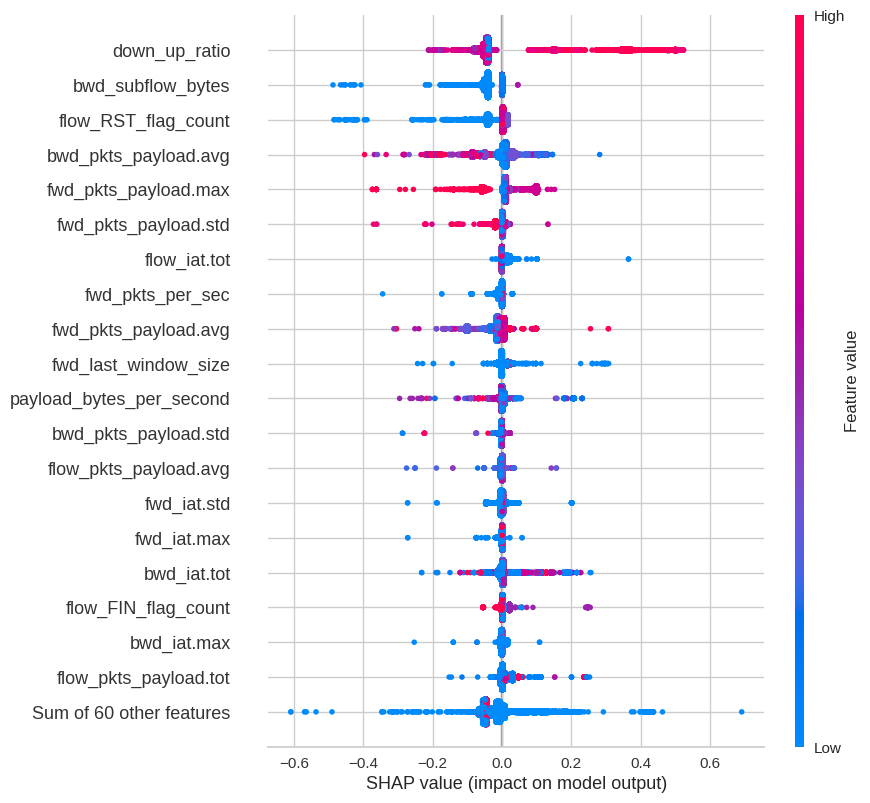

In [32]:
exp = Explanation(sv.values[:,:,4], 
                  sv.base_values[:,4],
                  data=X_train, 
                  feature_names=x_features)

plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

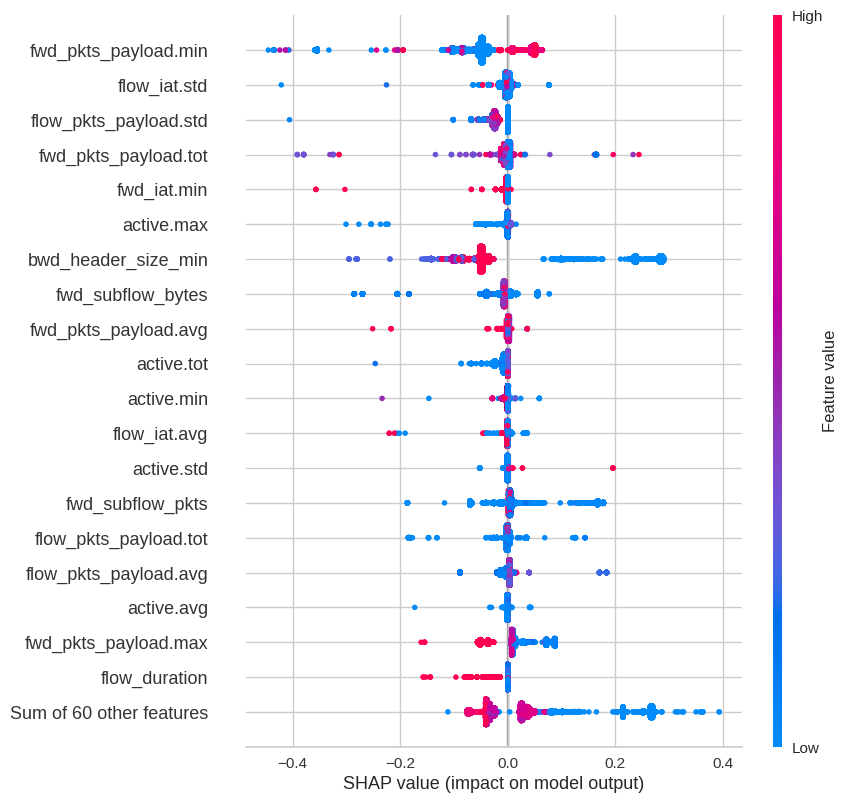

In [33]:
exp = Explanation(sv.values[:,:,5], 
                  sv.base_values[:,5],
                  data=X_train, 
                  feature_names=x_features)

plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

# Zero day

In [35]:
classes = sorted(pd.unique(ds['traffic_category']).tolist())

In [34]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Bruteforce']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
dt.fit(X_train_attack, y_train_attack)
y_predicted_train = dt.predict(X_train_attack)
y_predicted_test = dt.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Measure,Train,Test
0,ACCURACY,0.910710,0.739725
1,PRECISION,0.911364,0.641952
2,RECALL,0.910710,0.739725
3,F1 SCORE,0.907692,0.684332


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


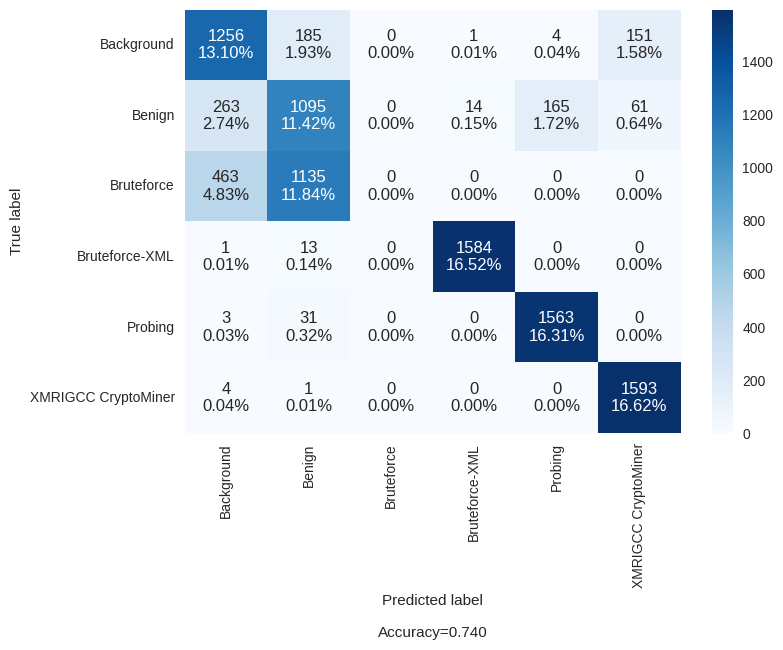

In [36]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [37]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Bruteforce-XML']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
dt.fit(X_train_attack, y_train_attack)
y_predicted_train = dt.predict(X_train_attack)
y_predicted_test = dt.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Measure,Train,Test
0,ACCURACY,0.913120,0.739412
1,PRECISION,0.913337,0.649992
2,RECALL,0.913120,0.739412
3,F1 SCORE,0.910327,0.687331


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


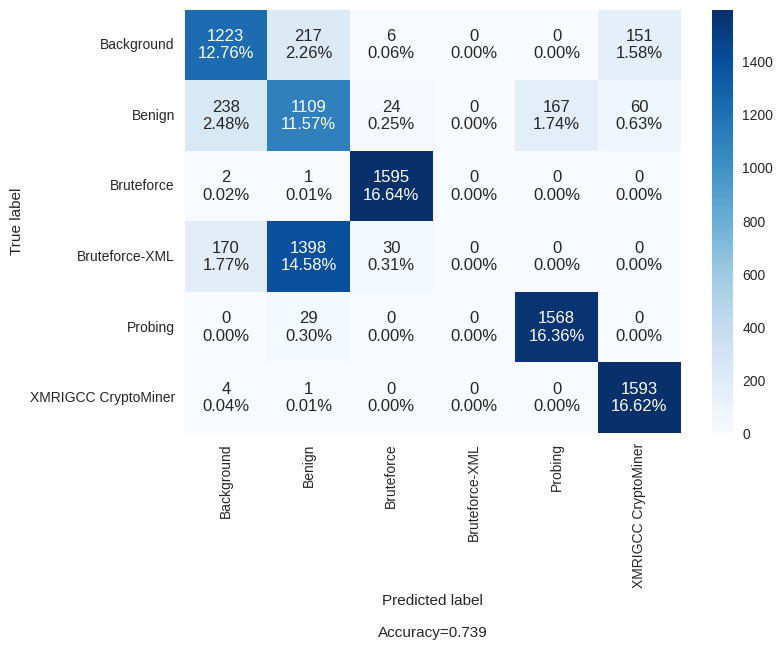

In [38]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [39]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Probing']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
dt.fit(X_train_attack, y_train_attack)
y_predicted_train = dt.predict(X_train_attack)
y_predicted_test = dt.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Measure,Train,Test
0,ACCURACY,0.936778,0.758606
1,PRECISION,0.937853,0.683634
2,RECALL,0.936778,0.758606
3,F1 SCORE,0.935851,0.710069


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


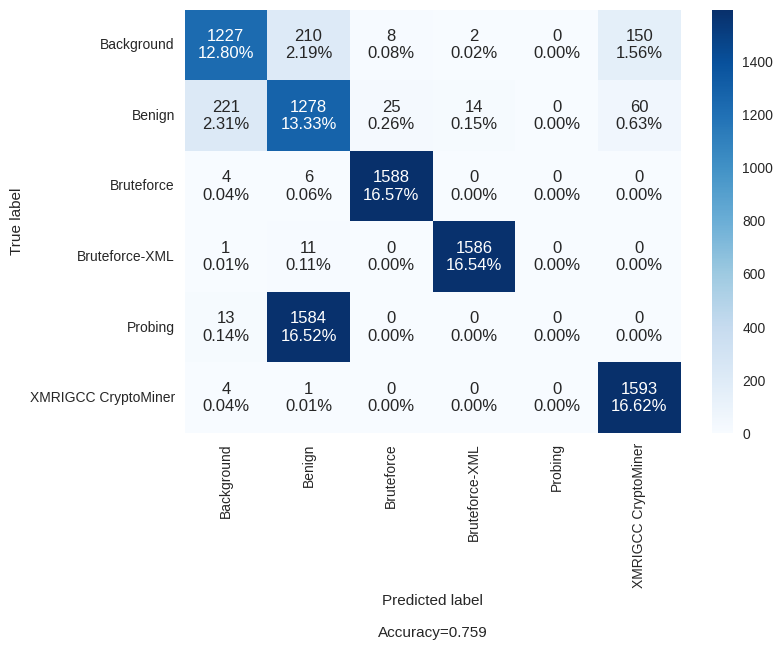

In [40]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [41]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'XMRIGCC CryptoMiner']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
dt.fit(X_train_attack, y_train_attack)
y_predicted_train = dt.predict(X_train_attack)
y_predicted_test = dt.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Measure,Train,Test
0,ACCURACY,0.931710,0.752243
1,PRECISION,0.932098,0.676692
2,RECALL,0.931710,0.752243
3,F1 SCORE,0.929468,0.702369


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


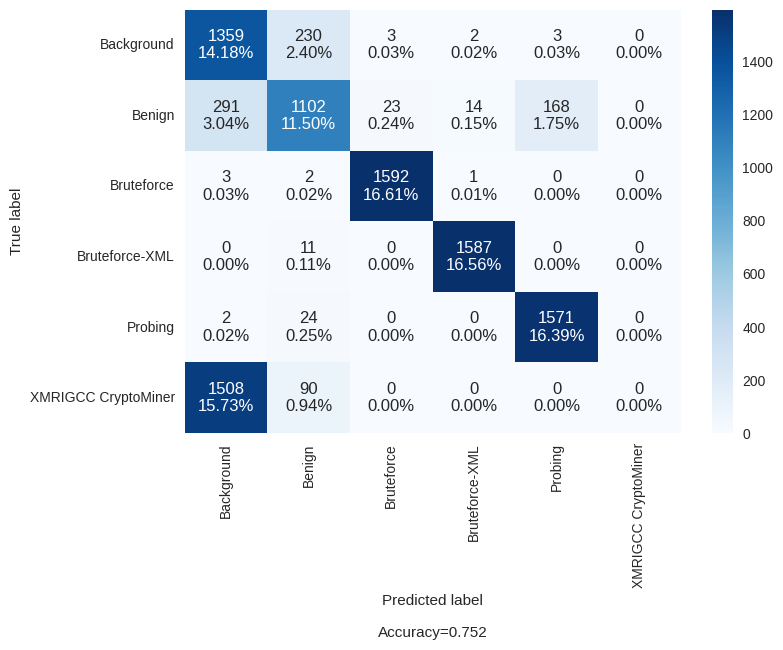

In [42]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')